In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/content/drive/My Drive/phd")
sys.path.append("/content/drive/My Drive/phd/hsbm-occam")
from hsbmpy import get_max_available_L

os.environ["TF_CUDNN_USE_AUTOTUNE"]="0"
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/cancers/breast'
L = 0
os.chdir(directory)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
!pip install pyspark

import pyspark as spark
from pyspark.sql import SparkSession
ss = SparkSession.builder.master("local[*]").getOrCreate()
sc = ss.sparkContext

from pyspark.sql.functions import col
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
sql = spark.sql.SparkSession(sc)

In [0]:
label = 'Subtype_Selected_Lum'

df_topics = sql.read.option("header", True).csv("%s/topsbm_all/%s_level_%d_topic-dist.csv"%(directory,algorithm,L)).drop("i_doc")
df_words = sql.read.option("header", True).csv("%s/topsbm_all/%s_level_%d_word-dist.csv"%(directory,algorithm,L))
df = sql.read.option("header", True).csv("%s/mainTable.csv"%directory)
df_files = sql.read.option("header", True).csv("%s/files.dat"%(directory))
df_words.registerTempTable("words")
df.registerTempTable("df")
df_files.registerTempTable("files")
df_words = sql.sql("SELECT * FROM words WHERE _c0 IN (SELECT 0 FROM df)")
df_files=df_files.filter(col("file_name").isin(df.columns))
df=df.drop("0")
df_topics=df_topics.drop("doc")

In [0]:
classes = df_files.select("Subtype_Selected_Lum").distinct()

In [0]:
from pyspark.ml.linalg import Vectors

_,labels = np.unique(df_files.select(label).collect(), return_inverse=True)
# Load training data
data = ss.createDataFrame([(float(label),Vectors.dense(feature)) for label,feature in zip(labels, df_topics.collect())], ["label","features"])

# Split the data into train and test
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [42]:
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [len(df_topics.columns), 50, classes.count()]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=500, layers=layers, blockSize=50, seed=314)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="f1")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))
print("Test set F1 = " + str(MulticlassClassificationEvaluator(metricName="f1").evaluate(predictionAndLabels)))

Test set accuracy = 0.9152496868402945
Test set F1 = 0.9152496868402945


In [35]:
predictionAndLabels.sample(fraction=.1).take(10)

[Row(prediction=0.0, label=0.0),
 Row(prediction=0.0, label=0.0),
 Row(prediction=2.0, label=2.0),
 Row(prediction=2.0, label=2.0),
 Row(prediction=2.0, label=2.0),
 Row(prediction=2.0, label=2.0),
 Row(prediction=2.0, label=2.0),
 Row(prediction=1.0, label=2.0),
 Row(prediction=2.0, label=2.0),
 Row(prediction=2.0, label=2.0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


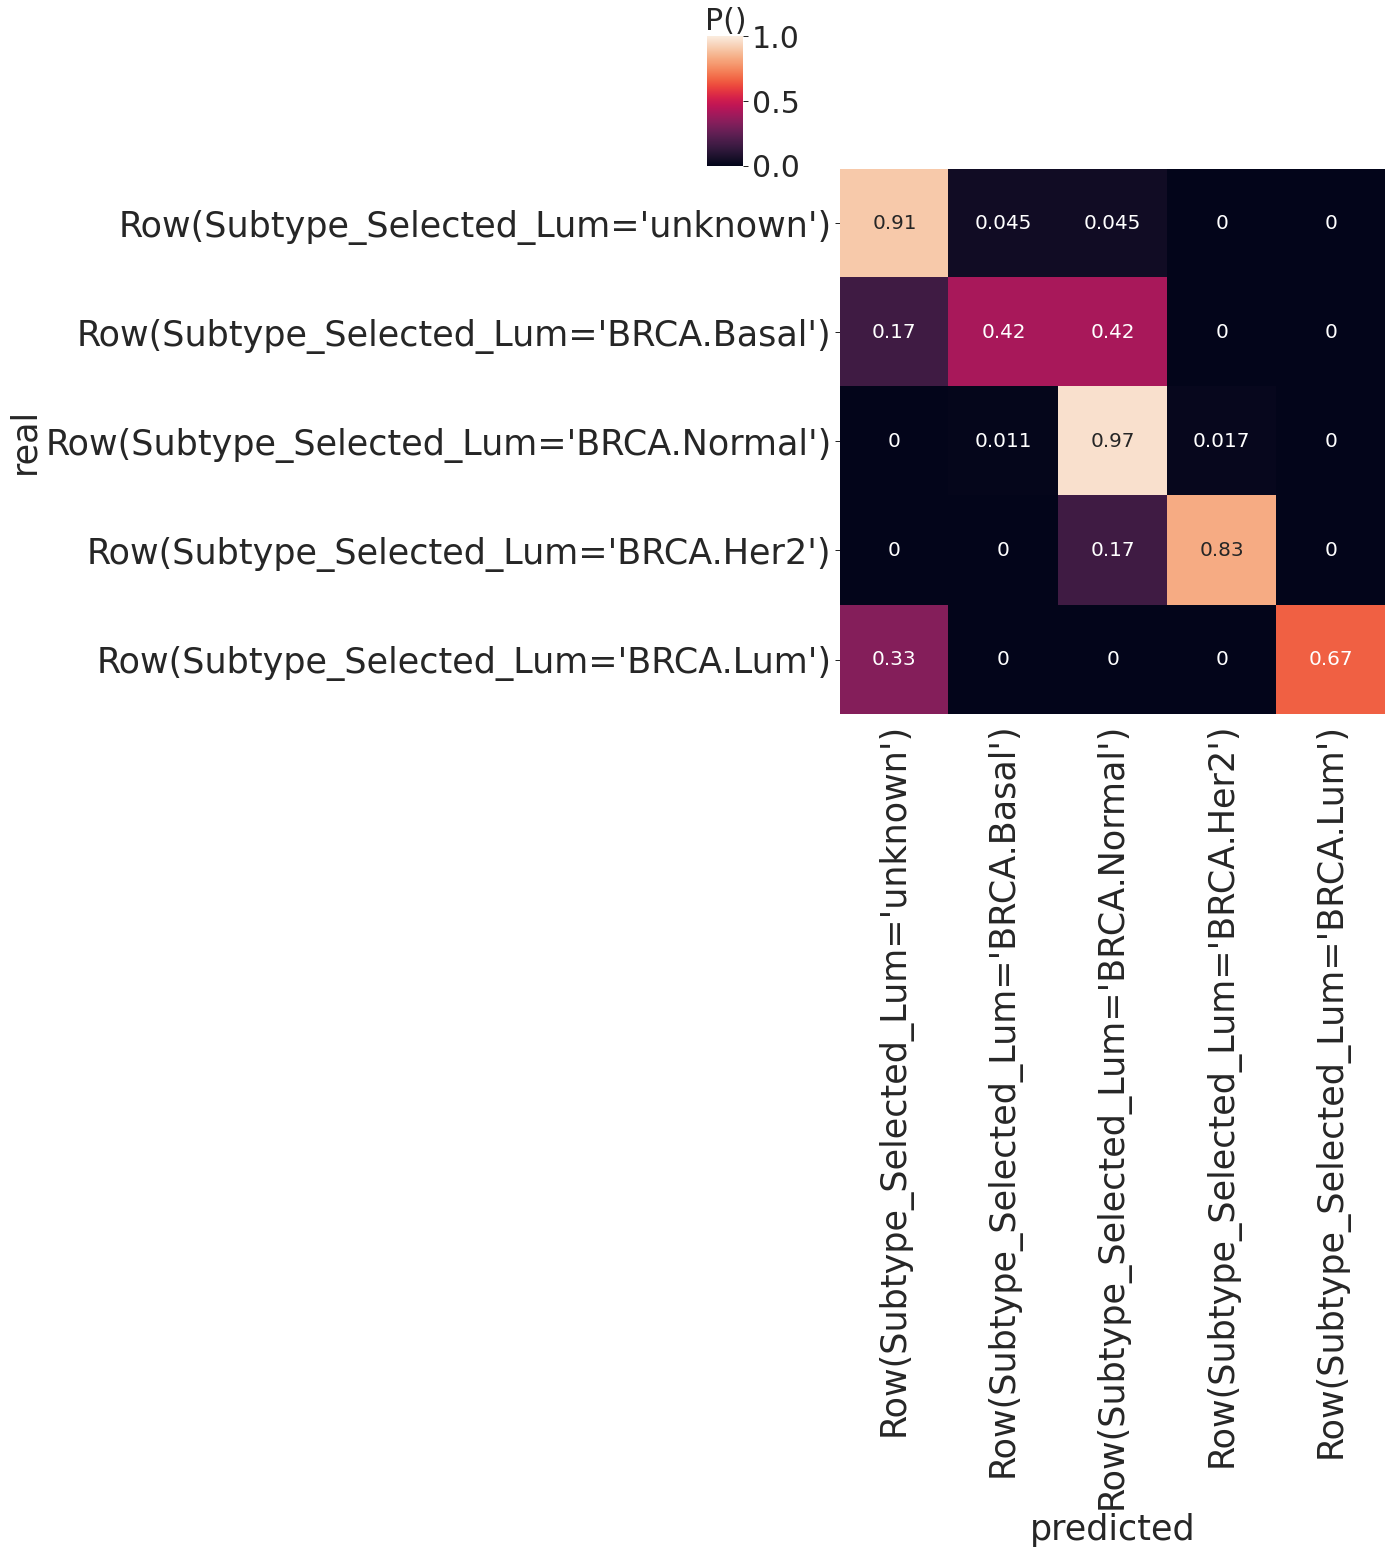

In [41]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

y_true = predictionAndLabels.select("label").collect()
y_pred = predictionAndLabels.select("prediction").collect()
results = confusion_matrix(y_true, y_pred, normalize="true")

cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes.collect(), 
                    yticklabels=classes.collect(), 
                    annot=False,
                    annot_kws={"fontsize":20})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes.collect(), rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes.collect(), rotation=90)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()

plt.show()